# Working with frequency data - An introduction

most natural and social phenomena have an element of periodicity - a tendency to repeat in semi-regular ways, whether human daily acticity levels, to climate behaviour, to the information contained in audio data. 

Before you can start to analyse the data, you need to be able to understand how to manipulate and visualise it. Today's short lesson will be looking at how we can represent whalesong visually, and if there are any trends that we use machine learning to extract.

This lesson is a dive into the deeper end of 

First, python cannot easily handle audio data and the more complex maths we want to carry out, so we need to call in some libraries to augment the functionality of the language

In [13]:
import pandas as pd  #This helps us contain our data in easy to handle Dataframes
import numpy as np # This provides additional mathematical support for handling our data
import matplotlib.pyplot as plt #This allows us to plot simple graphs
from scipy.io import wavfile #This allows us to handle .wav audio files

from numpy.fft import * #a library for carrying out fourier mathematics
from scipy.signal import kaiser #a library for applying filters to audio data

from skimage import util #a library for slicing up audio data into windows

%matplotlib notebook 
#This is a bit of jupyter magic that lets us interact with our plots in the notebook

/home/users/lina3398/anaconda3/envs/non_deep_learning_ml/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Now that we've added all our needed libraries, let's pull in our audio file. Our wavfile module will tell us two things - the recording rate of our file, and the audio data itself, once we provide it with a path to our file.

In [2]:
recording_rate, audio_data = wavfile.read("./Data/Humpback whale song from Monterey Bay.wav")
audio_data.shape

(5297152, 2)

We can check our data with `.shape`, which tells is that we have 5297152 data points. But we have two of them, which means we have stereo data. As we don't need to worry about ahndling both streams independently, let's average them into a mono audio instead.

We need to specify that we want an average across the two channels - otherwise the `.mean` function would average down instead, leaving us with the average of the entire clip per channel - not very useful. 

We'll then check the shape again to see if it worked.

In [3]:
audio_data = np.mean(audio_data, axis = 1)
audio_data.shape

(5297152,)

Let's place this into a pandas Series (a one dimensional array of values) to make handling it easier down the line, and plot it to see what it looks like. We can take the time to properly set up our axes and labels, but right now we just want to visually verify the data we expect

<IPython.core.display.Javascript object>


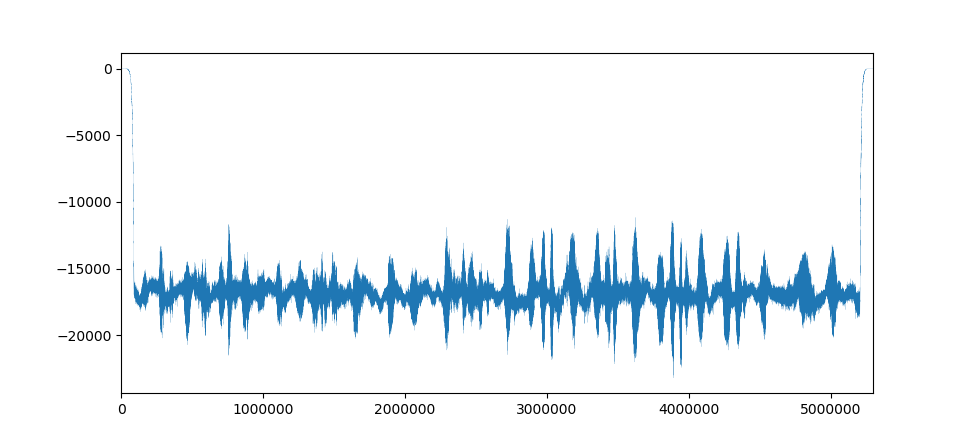

In [10]:
audio_data_series = pd.Series(audio_data)
audio_data_series.plot(lw = 0.1) #lw = line width

The data appears to be what we expect for an audiofile. There are high peaks at the beginning and the end, but this is just because of some padded silence at the beginning and end of the audio - nothing to worry about. If we want to analyse the data numerically later, we might want to clip away those areas, however.

### Power Spectrum

Now that we have the audio ready to go, we can start to visualise the frequency-domain information in the data. As humans, we don't percieve sound as a single fluctuating amplitude like in the plot above, but as a series of interlinked signals at different volumes and pitches - the higher the pitch, the higher the frequency of the sound. We can use a mathematical trick called kaiser transformation to flip the above graph around. Instead showing time across the x-axis and amplitude across the y-axis, we can show time across the x-axis, frequency across the y-axis, and then pixel intensity as amplitude.

We'll show this as discrete slices of time per analysis, all pushed together as a histogram-style representation of how the audio changes.

On a side note, we've chosen 1024 datapoints per slide as a tradeoff - too small a slice and we lose the lowest frequencies. Too high a window and we lose resolution. Finally, picking a $2^n$ number allows us to be mathematically efficient.

In [19]:
datapoints_per_slice = 1024

audio_slices = util.view_as_windows(audio_data, window_shape = (datapoints_per_slice,), step = 100)

There is a weakness with the version of the fourier transform used with modern computers - it often introduces small artefacts on the sides of the window slices that can add noise to the final product. We need to apply a *windowing filter* to reduce the weighting of the sides of th window. There are quite a few options, but we're going with the *hanning* window today.

First we need to create an equal number of filter windows to audio windows, and then we can multiply them together to produced a cleaned version of our audio data.

In [20]:
win = np.hanning(datapoints_per_slice + 1)[:-1] #Here, we are slightly stretching the window size and then selecting
                                                #n - 1 windows to match the slices.
audio_slices = slices * win

We want to analyse each slice/window independently, but our data is organised such that we'd end up looking across slices instead. We'll transpose the data around, and then use a fourier library to calculate the power spectra.

We need to do a little mathematical trickery, as the fourier will produce its values as compound real + imaginary numbers - something it does to support every possible use of fouriers. However, because we are analysing a real audio file, we can confidently remove the imaginary compnonts with a absolute (`abs()`) function.

One last point is that the fourier equation requires an even number of datapoints, so we have a little juggle below so ensure this will work no matter what our window size is.


In [22]:
spectrum = np.fft.fft(audio_slices, axis = 0)[:datapoints_per_slice // 2 + 1:-1] #juggle here
spectrum = np.abs(spectrum)

We're almost there - we just need to scale our amplitude. The usual way to do this is to use decibels:

$$ decibel = 20\log_{10}\left(\frac{amplitude}{max\ amplitude}\right) $$

In [23]:
decibels = 20*np.log10(spectrum / np.max(spectrum))

/home/users/lina3398/anaconda3/envs/non_deep_learning_ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Now we can plot our spectrogram!

In [ ]:
f, ax = plt.subplots(figsize = (4.8, 2.4))

ax.imshow()